In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer
import sys
import os
sys.path.append(os.path.abspath(".."))
import src.woe as woe

In [22]:
# Load the data
train_balanced = pd.read_csv(r'C:\Users\user\Desktop\BatiBank_SmartCredit\data\train_balanced.csv')

In [23]:
# Construct the RFMS scores 
train_balanced['RFMS_Score'] = (train_balanced['Recency'] * 0.4) + (train_balanced['Frequency'] * 0.3) + (train_balanced['Monetary'] * 0.3)

# Now we classify users into 'good' (1) or 'bad' (0) based on RFMS_Score.
# Define threshold (for demonstration, let's say above the median score is good, below is bad)
threshold = train_balanced['RFMS_Score'].median()

# Assigning the target 'good' (1) or 'bad' (0) based on RFMS score
train_balanced['target'] = np.where(train_balanced['RFMS_Score'] >= threshold, 1, 0)

# Check the distribution of the target variable
print(train_balanced['target'].value_counts())


target
0    76372
1    76372
Name: count, dtype: int64


In [24]:
# Define the list of continuous features for WoE binning
continuous_features = ['Amount', 'Recency', 'Frequency', 'Monetary', 'customer_total_amount', 'customer_mean_amount', 'customer_transaction_count', 'customer_amount_std']

# Apply WoE binning to each continuous feature
for feature in continuous_features:
    train_balanced, _ = woe.calculate_woe(train_balanced, feature, 'target')

# Check the results
train_balanced.head()


,Amount,PricingStrategy,Month,Day,Hour,Weekday,IsWeekend,ProductCategory_Amount_Mean,customer_total_amount,customer_mean_amount,...,binned_Monetary,woe_Monetary,binned_customer_total_amount,woe_customer_total_amount,binned_customer_mean_amount,woe_customer_mean_amount,binned_customer_transaction_count,woe_customer_transaction_count,binned_customer_amount_std,woe_customer_amount_std
0,-0.056453,-0.34828,-1.064909,-0.321961,-0.919098,1.604086,1.959418,0.626597,0.172292,-0.064638,...,"(-0.328, 0.536]",-0.689486,"(-0.328, 0.536]",-0.689486,"(-5.305, 5.667]",-0.407628,"(-0.451, 0.0196]",-0.024872,"(-0.239, 3.462]",-0.686165
1,-0.015089,-0.34828,1.040922,0.571105,0.730544,0.531040,-0.510356,-0.783679,0.179151,-0.023416,...,"(-0.328, 0.536]",-0.689486,"(-0.328, 0.536]",-0.689486,"(-5.305, 5.667]",-0.407628,"(-0.451, 0.0196]",-0.024872,"(-0.239, 3.462]",-0.686165
2,-0.047531,-0.34828,-1.064909,0.794371,1.142955,-0.542005,-0.510356,-0.783679,0.171434,-0.061053,...,"(-0.328, 0.536]",-0.689486,"(-0.328, 0.536]",-0.689486,"(-5.305, 5.667]",-0.407628,"(-0.451, 0.0196]",-0.024872,"(-0.239, 3.462]",-0.686165
3,-0.056209,-0.34828,-1.064909,-0.433594,-0.300482,1.067563,1.959418,0.626597,0.185842,-0.066662,...,"(-0.328, 0.536]",-0.689486,"(-0.328, 0.536]",-0.689486,"(-5.305, 5.667]",-0.407628,"(-0.451, 0.0196]",-0.024872,"(-0.239, 3.462]",-0.686165
4,0.106567,-0.34828,-0.873470,-0.880127,-1.125304,0.531040,-0.510356,-0.783679,0.275953,-0.030453,...,"(-0.328, 0.536]",-0.689486,"(-0.328, 0.536]",-0.689486,"(-5.305, 5.667]",-0.407628,"(0.0196, 0.486]",-1.297123,"(-0.239, 3.462]",-0.686165


In [27]:
# Compute percentiles for Recency, Frequency, and Monetary
recency_percentile = train_balanced['Recency'].quantile(0.5)
frequency_percentile = train_balanced['Frequency'].quantile(0.5)
monetary_percentile = train_balanced['Monetary'].quantile(0.5)

# Create the 'Label' column based on these percentiles
train_balanced['Label'] = train_balanced.apply(
    lambda row: 'Good' if (row['Recency'] <= recency_percentile and 
                           row['Frequency'] >= frequency_percentile and 
                           row['Monetary'] >= monetary_percentile) else 'Bad',
    axis=1
)

# Check the distribution of the new labels
train_balanced['Label'].value_counts()

Label
Bad     126666
Good     26078
Name: count, dtype: int64

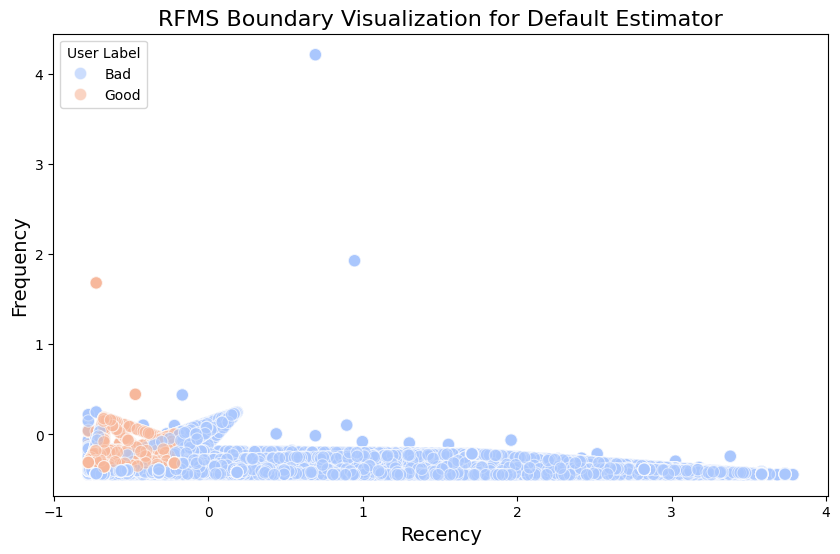

In [28]:
# A scatter plot for visualizing the boundary
plt.figure(figsize=(10, 6))

# Choose Recency and Frequency as primary and secondary axes
sns.scatterplot(x='Recency', y='Frequency', data=train_balanced, hue='Label', palette='coolwarm', s=80, alpha=0.6)

plt.title('RFMS Boundary Visualization for Default Estimator', fontsize=16)
plt.xlabel('Recency', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(title='User Label', loc='upper left')

plt.show()

In [29]:
# Drop unnecessary columns
X_final = train_balanced.drop(columns=['FraudResult', 'binned_Amount', 'binned_Recency', 
                                       'binned_Frequency', 'binned_Monetary', 
                                       'binned_customer_total_amount', 'binned_customer_mean_amount', 
                                       'binned_customer_transaction_count', 'binned_customer_amount_std'])

# Save the relevant features and target
X_final.to_csv(r'C:\Users\user\Desktop\BatiBank_SmartCredit\data\final_features.csv', index=False)
y = train_balanced['target']
y.to_csv(r'C:\Users\user\Desktop\BatiBank_SmartCredit\data\target.csv', index=False)

### **Summary of Performance in Default Estimator and WoE Binning**

The analysis involved constructing RFMS scores to classify users based on their Recency, Frequency, and Monetary values. The RFMS score was computed as follows:

- **RFMS Score**: 
  RFMS Score = (0.4 * Recency) + (0.3 * Frequency) + (0.3 * Monetary)

A threshold was defined using the median RFMS score to categorize users into 'Good' (1) or 'Bad' (0). The distribution showed a balanced dataset with 76,372 instances for both categories.

#### **Label Classification**
Additionally, labels were created based on percentiles for Recency, Frequency, and Monetary values, resulting in:

- **Good**: 26,078 instances
- **Bad**: 126,666 instances

This indicates a substantial imbalance, with a higher proportion of 'Bad' labels.

#### **Visualization**
A scatter plot was generated to visualize the RFMS boundaries, showing a clear distinction between 'Good' and 'Bad' users based on their scores in the Recency and Frequency dimensions.

### **Key Insights**
- The RFMS scoring effectively differentiated between user segments.
- The significant imbalance in labels suggests potential areas for further exploration or adjustments in the classification strategy.
- Visualization aids in understanding user distribution and the effectiveness of the scoring system.